In [4]:
# 1. Import Cleaned Data for Analysis
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import plotly.graph_objs as go
import pycountry
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

input_file = 'data_cleaned.csv'
data_cleaned = pd.read_csv(input_file, index_col=[0, 1])

In [5]:
# 2. MCAR Test
# Create a function to perform a basic MCAR test using random sampling
def mcar_test(data):
    from scipy.stats import chi2_contingency

    # Create a binary mask for missing values
    missing_mask = data.isnull().astype(int)

    # Calculate the expected and observed frequencies for missing values
    observed = missing_mask.sum(axis=0)
    expected = np.full_like(observed, observed.mean())

    # Perform chi-squared test
    chi2, p_value, _, _ = chi2_contingency([observed, expected])
    return p_value

# Perform MCAR test on the original cleaned data
p_value = mcar_test(data_cleaned)
print("MCAR test result:")
if p_value < 0.05:
    print("The missing data is not MCAR (p < 0.05).")
else:
    print("The missing data is MCAR (p >= 0.05).")

# 2.1. MAR Test
# Create a function to test if missing data is MAR using logistic regression
def mar_test(data):
    missing_mask = data.isnull().astype(int)
    results = {}

    for column in data.columns:
        if missing_mask[column].sum() > 0:
            # Prepare the target and features
            target = missing_mask[column]
            features = data.drop(columns=[column]).fillna(0)

            # Standardize the features to help with convergence
            scaler = StandardScaler()
            features = scaler.fit_transform(features)

            # Split the data into training and testing sets
            X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

            # Fit a logistic regression model
            model = LogisticRegression(max_iter=2000)
            model.fit(X_train, y_train)

            # Predict and calculate accuracy
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)

            # Store the result
            results[column] = accuracy

    return results

# Perform MAR test on the original cleaned data
mar_results = mar_test(data_cleaned)
print("\nMAR test result:")
for column, accuracy in mar_results.items():
    print(f"MAR Test for column '{column}': Accuracy = {accuracy:.2f}")

MCAR test result:
The missing data is not MCAR (p < 0.05).

MAR test result:
MAR Test for column '1992': Accuracy = 0.93
MAR Test for column '1993': Accuracy = 0.96
MAR Test for column '1994': Accuracy = 0.96
MAR Test for column '1995': Accuracy = 0.99
MAR Test for column '1996': Accuracy = 1.00
MAR Test for column '1997': Accuracy = 1.00
MAR Test for column '2014': Accuracy = 1.00
MAR Test for column '2015': Accuracy = 1.00
MAR Test for column '2016': Accuracy = 1.00
MAR Test for column '2017': Accuracy = 1.00
MAR Test for column '2018': Accuracy = 1.00
MAR Test for column '2019': Accuracy = 0.99
MAR Test for column '2020': Accuracy = 0.99
MAR Test for column '2021': Accuracy = 0.56


In [6]:
# 3. Imputation
# Use linear interpolation to fill in missing values
data_imputation = data_cleaned.interpolate(method='linear', axis=1, limit_direction='both')

# Check if there are any missing values after imputation. If there are, fill them with the previous or next value.
if data_imputation.isnull().values.any():
    data_imputation = data_imputation.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)

# Check if there are any missing values after imputation
missing_values = data_imputation.isnull().sum().sum()
if missing_values > 0:
    print(f"Warning: There are still {missing_values} missing values in the data. Check specific rows or columns.")
else:
    print("All missing values have been filled.")

# Save the imputed data to a new file
data_imputation.to_csv('data_imputation.csv')

All missing values have been filled.



<div style="width: 100%; max-width: 100%; background-color: #fefefe; border: 1px solid #333; border-radius: 10px; padding: 20px; font-family: Arial, sans-serif; box-sizing: border-box;">
  <h3 style="color: #2c3e50; text-align: center;">Imputation</h2>
  
  <p style="color: #34495e; line-height: 1.6;">
    Since the heavily missing data has already been dropped during the data cleaning phase, the remaining missing data is relatively minor. Moreover, there is a strong correlation between consecutive years for the same feature. Therefore, we do not need to use complex data imputation methods here; linear interpolation based on neighboring values would be sufficient.
    
  <p style="color: #34495e; line-height: 1.6;">
    However, to be thorough, I conducted MCAR and MAR tests. Previously, I established that both the electrical and economic data are highly correlated internally, and the test results confirmed that the missing data is not MCAR. For MAR, the prediction accuracy for missing values in each column was quite high, indicating that the data follows a MAR pattern. The lower accuracy for 2021 is due to all economic data being available only up to 2020, resulting in no relevant data for 2021.
    
  </p>
  
</div>

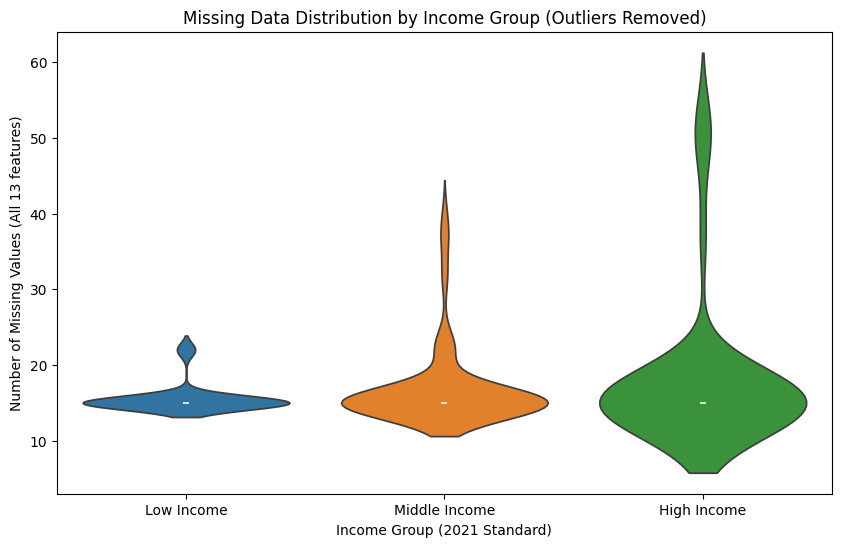

In [7]:
# 3.1. Group countries based on GDP per capita
gdp_per_capita = data_cleaned.xs('Economics: GDP Per Capita', level=1)
median_gdp_per_country = gdp_per_capita.median(axis=1)

# Define GDP thresholdd
income_thresholds = {
    1992: {'low_income': 675, 'high_income': 8325},
    1993: {'low_income': 695, 'high_income': 8645},
    1994: {'low_income': 725, 'high_income': 8955},
    1995: {'low_income': 765, 'high_income': 9355},
    1996: {'low_income': 785, 'high_income': 9635},
    1997: {'low_income': 785, 'high_income': 9655},
    1998: {'low_income': 760, 'high_income': 9855},
    1999: {'low_income': 755, 'high_income': 9955},
    2000: {'low_income': 755, 'high_income': 9955},
    2001: {'low_income': 745, 'high_income': 9355},
    2002: {'low_income': 735, 'high_income': 9355},
    2003: {'low_income': 735, 'high_income': 9655},
    2004: {'low_income': 765, 'high_income': 10065},
    2005: {'low_income': 875, 'high_income': 10365},
    2006: {'low_income': 905, 'high_income': 10655},
    2007: {'low_income': 935, 'high_income': 10855},
    2008: {'low_income': 975, 'high_income': 11355},
    2009: {'low_income': 995, 'high_income': 11655},
    2010: {'low_income': 1005, 'high_income': 12275},
    2011: {'low_income': 1025, 'high_income': 12375},
    2012: {'low_income': 1035, 'high_income': 12575},
    2013: {'low_income': 1045, 'high_income': 12615},
    2014: {'low_income': 1045, 'high_income': 12735},
    2015: {'low_income': 1045, 'high_income': 12635},
    2016: {'low_income': 1005, 'high_income': 12475},
    2017: {'low_income': 995, 'high_income': 12475},
    2018: {'low_income': 995, 'high_income': 12375},
    2019: {'low_income': 1025, 'high_income': 12375},
    2020: {'low_income': 1035, 'high_income': 12535},
    2021: {'low_income': 1045, 'high_income': 12695}
}

year = 2021
thresholds = income_thresholds[year]
low_income_threshold = thresholds['low_income']
high_income_threshold = thresholds['high_income']

# Create groups
low_income_countries = median_gdp_per_country[median_gdp_per_country < low_income_threshold].index
middle_income_countries = median_gdp_per_country[(median_gdp_per_country >= low_income_threshold) & (median_gdp_per_country <= high_income_threshold)].index
high_income_countries = median_gdp_per_country[median_gdp_per_country > high_income_threshold].index

# Count missing values for each country across all features
missing_counts_per_country = data_cleaned.isnull().groupby(level=0).sum().sum(axis=1)

# Calculate missing data counts for each group and remove outliers, exclude countries with no missing values
low_income_missing = missing_counts_per_country.loc[low_income_countries]
low_income_missing = low_income_missing[low_income_missing > 0]
low_income_missing = low_income_missing[low_income_missing <= low_income_missing.quantile(0.95)]

middle_income_missing = missing_counts_per_country.loc[middle_income_countries]
middle_income_missing = middle_income_missing[middle_income_missing > 0]
middle_income_missing = middle_income_missing[middle_income_missing <= middle_income_missing.quantile(0.95)]

high_income_missing = missing_counts_per_country.loc[high_income_countries]
high_income_missing = high_income_missing[high_income_missing > 0]
high_income_missing = high_income_missing[high_income_missing <= high_income_missing.quantile(0.95)]

# Create a DataFrame for violin plot visualization
grouped_missing_data = pd.DataFrame({
    'Low Income': low_income_missing,
    'Middle Income': middle_income_missing,
    'High Income': high_income_missing
})

# Plot violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=grouped_missing_data, orient='v')
plt.xlabel('Income Group (2021 Standard)')
plt.ylabel('Number of Missing Values (All 13 features)')
plt.title('Missing Data Distribution by Income Group (Outliers Removed)')
plt.show()


<div style="width: 100%; max-width: 100%; background-color: #fefefe; border: 1px solid #333; border-radius: 10px; padding: 20px; font-family: Arial, sans-serif; box-sizing: border-box;">
  <h3 style="color: #2c3e50; text-align: center;">Missing data Distribution</h2>
  
  <p style="color: #34495e; line-height: 1.6;">
    I re-plotted all the graphs using the data after imputation. The overall trends remained largely unchanged, but some features became more pronounced. For instance, in the final histogram, self-sufficient countries now have a higher Normalized Median GDP per Capita, while the proportion of low-income populations showed little change, implying a reduced income gap.
    
  <p style="color: #34495e; line-height: 1.6;">
    In the heatmap, most correlations were strengthened. Notably, the growth rate of GDP or PPP per capita changed from having little correlation to showing a strong positive correlation with electricity data. This suggests that the missing data might primarily come from upper-middle-income countries, highlighting a strong connection between economics development and electricity development. Determining the causal relationship or whether they mutually reinforce each other will require further analysis.
    
  </p>
  
</div>

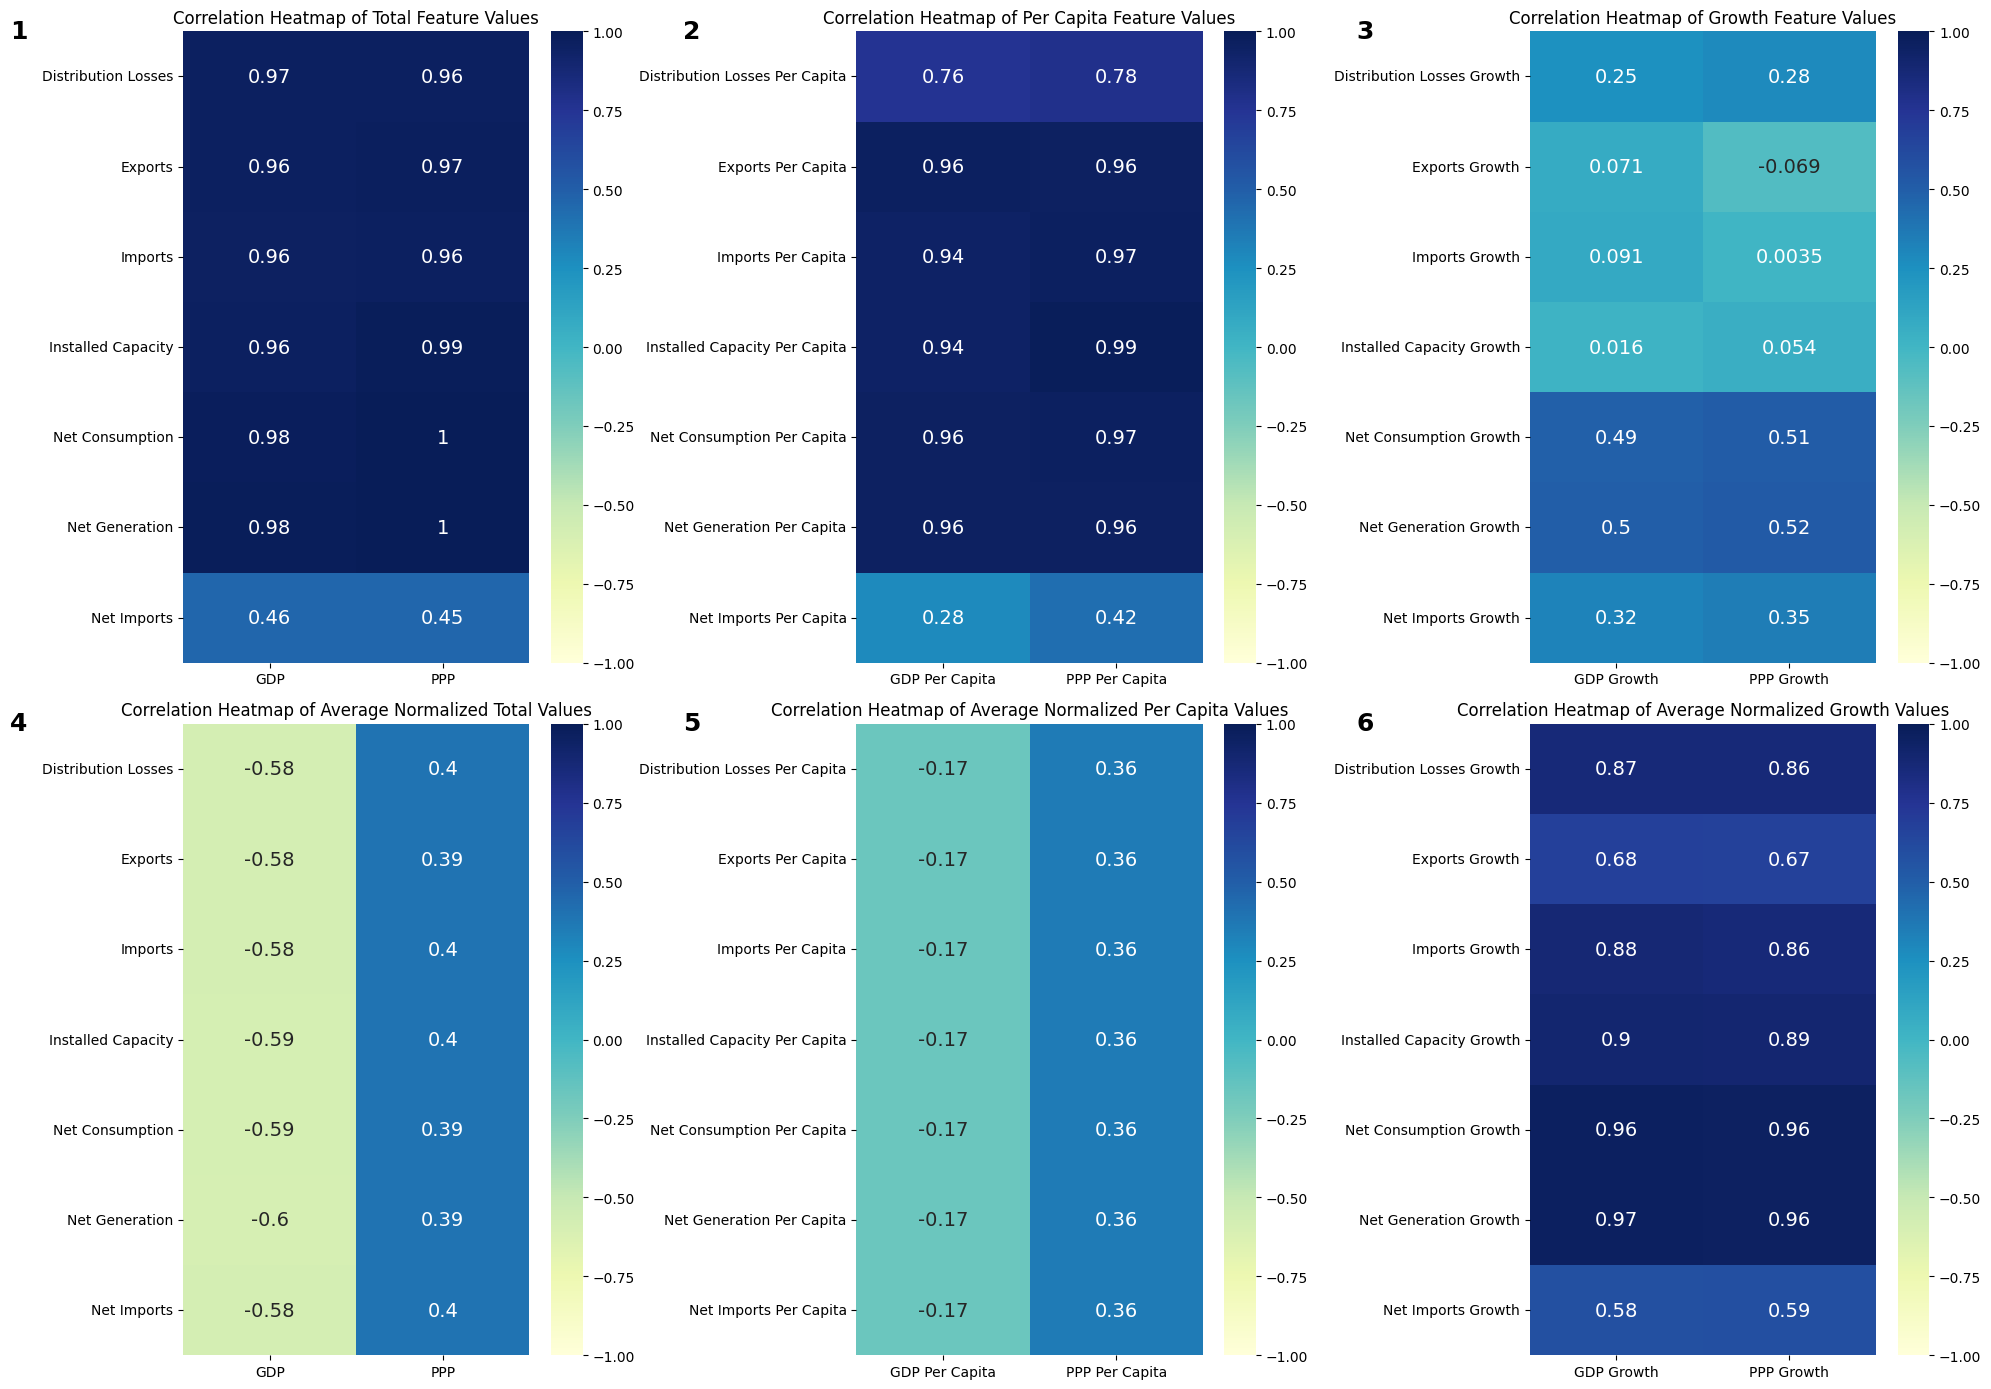

<Figure size 640x480 with 0 Axes>

In [8]:
# 2. Heatmap Analysis
# 2.1 Calculate the total values for each feature across all countries
# Sum the values for each feature independently
total_values = data_imputation.groupby(level=1).sum()

# Calculate the correlation matrix for total values
correlation_total = total_values.T.corr()

# 2.2 Normalize data for each country to ensure equal weight for all countries
normalized_data = data_imputation.groupby(level=0).transform(lambda x: (x - x.min()) / (x.max() - x.min()))

# Calculate the average values for each feature across all countries after normalization
average_normalized_values = normalized_data.groupby(level=1).mean()

# Calculate the correlation matrix for average normalized values
correlation_average = average_normalized_values.T.corr()

# 2.3 Plot the heatmaps
fig, axes = plt.subplots(2, 3, figsize=(20, 14))

# Extract different types of features
total_features = [col for col in data_imputation.index.levels[1] if not ('Per Capita' in col or 'Growth' in col)]
per_capita_features = [col for col in data_imputation.index.levels[1] if 'Per Capita' in col]
growth_features = [col for col in data_imputation.index.levels[1] if 'Growth' in col]

# Calculate correlation matrices for total, per capita, and growth features
total_corr = data_imputation.loc[(slice(None), total_features), :].groupby(level=1).sum().T.corr()
per_capita_corr = data_imputation.loc[(slice(None), per_capita_features), :].groupby(level=1).sum().T.corr()

gdp_values = data_imputation.xs('Economics: GDP', level=1)
weights = gdp_values.div(gdp_values.sum(axis=0), axis=1)
growth_weighted_sum = data_imputation.loc[(slice(None), growth_features), :].mul(weights, level=0).groupby(level=1).sum()
growth_corr = growth_weighted_sum.T.corr()

# Calculate correlation matrices for normalized average values
total_avg_corr = normalized_data.loc[(slice(None), total_features), :].groupby(level=1).mean().T.corr()
per_capita_avg_corr = normalized_data.loc[(slice(None), per_capita_features), :].groupby(level=1).mean().T.corr()
growth_avg_corr = normalized_data.loc[(slice(None), growth_features), :].groupby(level=1).mean().T.corr()

# Custom label function to remove prefixes
def custom_label(label):
    return label.replace('Electricity: ', '').replace('Economics: ', '')

# Plot specific parts of heatmaps
x_subset1 = ['Economics: GDP', 'Economics: PPP']
y_subset1 = ['Electricity: Distribution Losses', 'Electricity: Exports', 'Electricity: Imports', 'Electricity: Installed Capacity', 'Electricity: Net Consumption', 'Electricity: Net Generation', 'Electricity: Net Imports']
sns.heatmap(total_corr.loc[y_subset1, x_subset1].rename(index=custom_label, columns=custom_label), annot=True, cmap='YlGnBu', ax=axes[0, 0], vmin=-1, vmax=1, annot_kws={"size": 14})
axes[0, 0].set_title('Correlation Heatmap of Total Feature Values')
axes[0, 0].text(-0.5, 1.02, f'{1}', transform=axes[0, 0].transAxes, fontsize=18, verticalalignment='top', fontweight='bold')

x_subset2 = ['Economics: GDP Per Capita', 'Economics: PPP Per Capita']
y_subset2 = ['Electricity: Distribution Losses Per Capita', 'Electricity: Exports Per Capita', 'Electricity: Imports Per Capita', 'Electricity: Installed Capacity Per Capita', 'Electricity: Net Consumption Per Capita', 'Electricity: Net Generation Per Capita', 'Electricity: Net Imports Per Capita']
sns.heatmap(per_capita_corr.loc[y_subset2, x_subset2].rename(index=custom_label, columns=custom_label), annot=True, cmap='YlGnBu', ax=axes[0, 1], vmin=-1, vmax=1, annot_kws={"size": 14})
axes[0, 1].set_title('Correlation Heatmap of Per Capita Feature Values')
axes[0, 1].text(-0.5, 1.02, f'{2}', transform=axes[0, 1].transAxes, fontsize=18, verticalalignment='top', fontweight='bold')

x_subset3 = ['Economics: GDP Growth', 'Economics: PPP Growth']
y_subset3 = ['Electricity: Distribution Losses Growth', 'Electricity: Exports Growth', 'Electricity: Imports Growth', 'Electricity: Installed Capacity Growth', 'Electricity: Net Consumption Growth', 'Electricity: Net Generation Growth', 'Electricity: Net Imports Growth']
sns.heatmap(growth_corr.loc[y_subset3, x_subset3].rename(index=custom_label, columns=custom_label), annot=True, cmap='YlGnBu', ax=axes[0, 2], vmin=-1, vmax=1, annot_kws={"size": 14})
axes[0, 2].set_title('Correlation Heatmap of Growth Feature Values')
axes[0, 2].text(-0.5, 1.02, f'{3}', transform=axes[0, 2].transAxes, fontsize=18, verticalalignment='top', fontweight='bold')

sns.heatmap(total_avg_corr.loc[y_subset1, x_subset1].rename(index=custom_label, columns=custom_label), annot=True, cmap='YlGnBu', ax=axes[1, 0], vmin=-1, vmax=1, annot_kws={"size": 14})
axes[1, 0].set_title('Correlation Heatmap of Average Normalized Total Values')
axes[1, 0].text(-0.5, 1.02, f'{4}', transform=axes[1, 0].transAxes, fontsize=18, verticalalignment='top', fontweight='bold')

sns.heatmap(per_capita_avg_corr.loc[y_subset2, x_subset2].rename(index=custom_label, columns=custom_label), annot=True, cmap='YlGnBu', ax=axes[1, 1], vmin=-1, vmax=1, annot_kws={"size": 14})
axes[1, 1].set_title('Correlation Heatmap of Average Normalized Per Capita Values')
axes[1, 1].text(-0.5, 1.02, f'{5}', transform=axes[1, 1].transAxes, fontsize=18, verticalalignment='top', fontweight='bold')

sns.heatmap(growth_avg_corr.loc[y_subset3, x_subset3].rename(index=custom_label, columns=custom_label), annot=True, cmap='YlGnBu', ax=axes[1, 2], vmin=-1, vmax=1, annot_kws={"size": 14})
axes[1, 2].set_title('Correlation Heatmap of Average Normalized Growth Values')
axes[1, 2].text(-0.5, 1.02, f'{6}', transform=axes[1, 2].transAxes, fontsize=18, verticalalignment='top', fontweight='bold')

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

In [9]:
# 3. Dividing the countries into 3 groups based on electricity import/export strategy
# 3.1 Calculate net import ratio
net_imports = data_imputation.xs('Electricity: Net Imports', level=1)
net_generation = data_imputation.xs('Electricity: Net Generation', level=1).replace(0, np.nan)  # Avoid division by zero
net_import_ratio = net_imports.div(net_generation)

# 3.2 Function to plot the net import ratio on the world map for each year
def plot_world_map(df, title):
    import plotly.graph_objects as go
    
    fig = go.Figure()

    years = df.columns  # Use the DataFrame columns as the years

    for year in years:
        # Filter the data for the current year
        filtered_df = df[year].dropna()  # Drop NaN values for the current year

        # Create a choropleth trace for the current year
        if title == 'Net Import Ratio Map with slider':
            colorscale = [
                [0.0, '#1B4F72'],
                [0.3, '#2E86C1'],
                [0.45, '#AED6F1'],
                [0.55, '#D7BDE2'],
                [0.7, '#884EA0'],
                [1.0, '#512E5F']
            ]
            colorbar = dict(
                tickvals=[-1.0, -0.05, 0.05, 1.0],
                ticktext=['-100%', '-5%', '5%', '100%'],
                len=0.8,
                lenmode='fraction'
            )
            hovertemplate = '<b>Country:</b> %{location}<br>' + '<b>Net Import Ratio:</b> %{z:.2%}<extra></extra>'
            zmin, zmax = -1.0, 1.0

        elif title == 'GDP per Capita with slider':
            colorscale = [
                [0.0, '#fee5d9'],
                [1000 / 80000, '#fcae91'],  # Place 1000 at approximately 1/3rd position
                [12000 / 80000, '#de2d26'],  # Place 12000 at approximately 2/3rd position
                [1.0, '#67000d']
            ]
            colorbar = dict(
                tickvals=[1000, 12000, 80000],
                ticktext=['1000', '12000', '80000'],
                len=0.8,
                lenmode='fraction'
            )
            hovertemplate = '<b>Country:</b> %{location}<br>' + '<b>GDP per Capita:</b> %{z:.2f}<extra></extra>'
            zmin, zmax = 0, 80000

        trace = go.Choropleth(
            locations=filtered_df.index,
            z=filtered_df.values,
            locationmode='country names',  # Correct locationmode value
            colorscale=colorscale,
            colorbar=colorbar,
            hovertemplate=hovertemplate,
            zmin=zmin,  # Set minimum value of color range
            zmax=zmax,  # Set maximum value of color range
            visible=False  # Set the trace to invisible initially
        )
        
        # Add the trace to the figure
        fig.add_trace(trace)

    # Set the first trace to visible
    fig.data[0].visible = True

    # Create animation steps
    steps = []
    for i, year in enumerate(years):
        step = dict(
            method='update',
            args=[{'visible': [False] * len(fig.data)},  # Set all traces to invisible
                  {'title_text': f'{title} - {year}', 'frame': {'duration': 1000, 'redraw': True}}],
            label=str(year)  # Set the label for each step
        )
        step['args'][0]['visible'][i] = True  # Set the current trace to visible
        steps.append(step)

    # Create the slider
    sliders = [dict(
        active=0,
        steps=steps,
        currentvalue={"prefix": "Year: ", "font": {"size": 14}},  # Increase font size for slider label
    )]

    # Update the layout of the figure with increased size and change the template
    fig.update_layout(
        title_text=title,  # Set the initial title
        title_font_size=24,  # Increase title font size
        title_x=0.5,  # Center the title
        geo=dict(
            showframe=True,
            showcoastlines=True,
            projection_type='natural earth',
            showcountries=True
        ),
        sliders=sliders,
        height=500,  # Set the height of the figure in pixels
        width=1000,  # Set the width of the figure in pixels
        font=dict(family='Arial', size=12),  # Customize font family and size for the whole figure
        margin=dict(t=80, l=50, r=50, b=50),  # Add margin for better layout spacing
        template='plotly'
    )

    # Show the figure
    fig.show()

plot_world_map(net_import_ratio, 'Net Import Ratio Map with slider')

plot_world_map(data_imputation.xs('Economics: GDP Per Capita', level=1), 'GDP per Capita with slider')

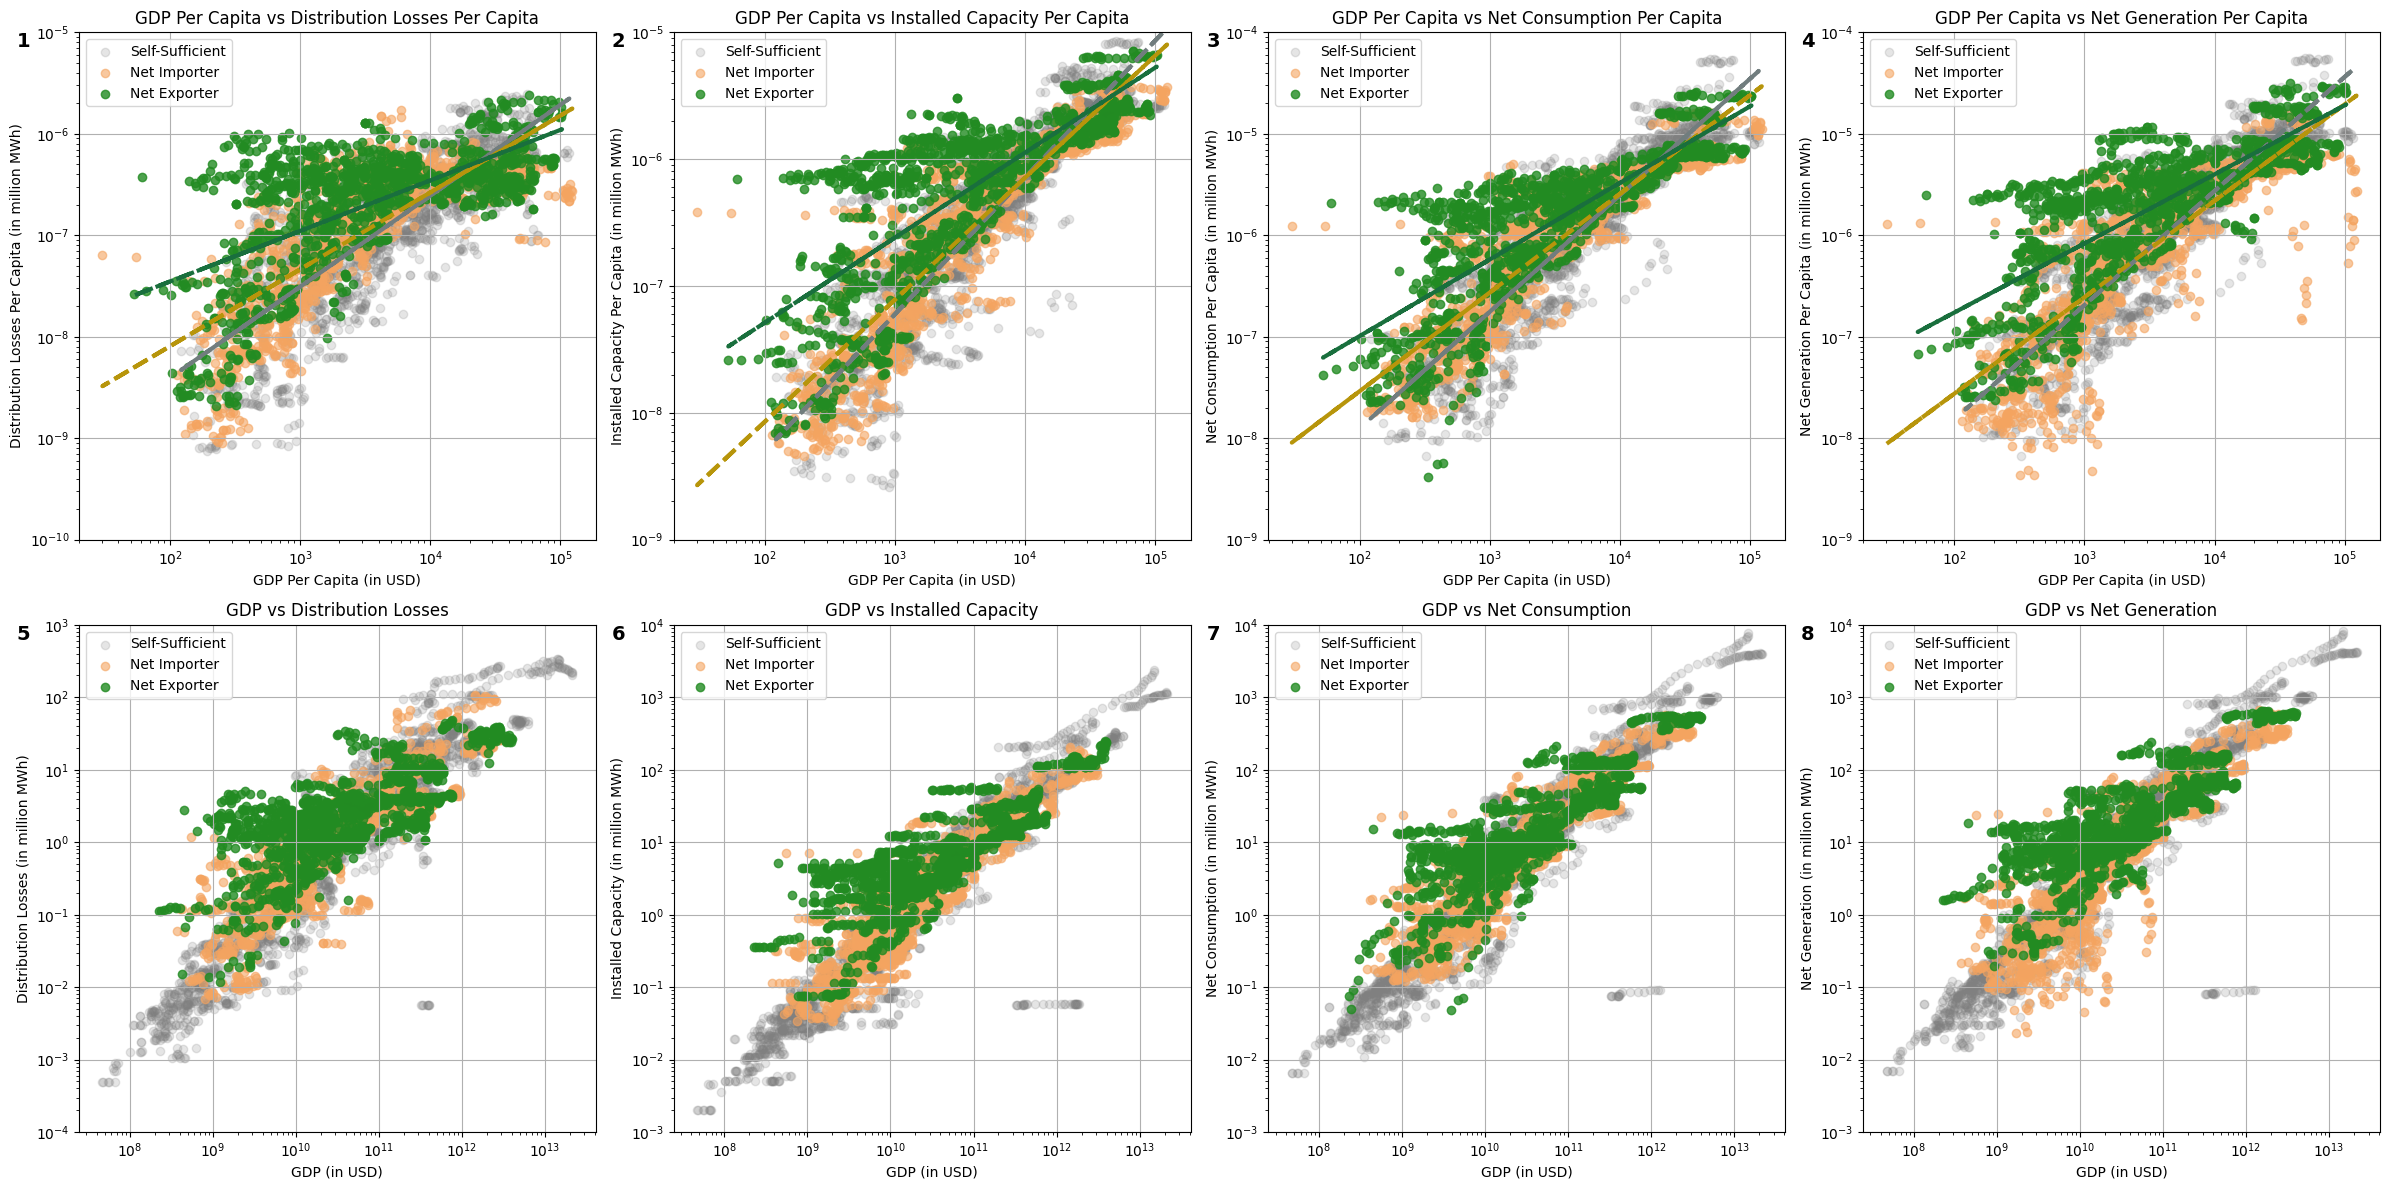

Net Importer Countries: 49
Net Exporter Countries: 46
Self-Sufficient Countries: 75
Switcher Countries: 0
Other Countries: 0


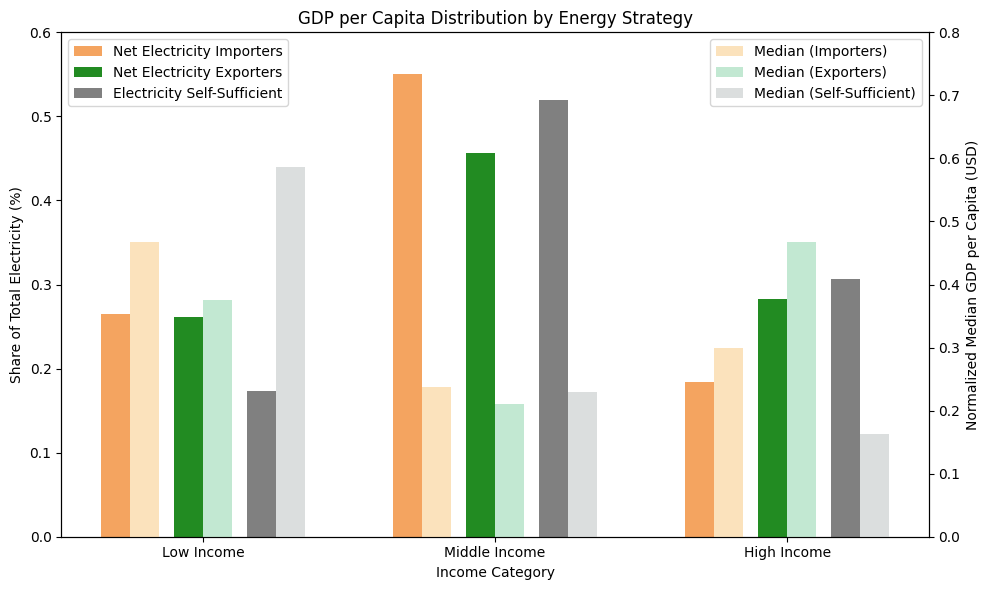

In [10]:
# 4. Scatter Plot Analysis
# 4.1 Classify energy status based on yearly net import ratio
net_import_ratio_threshold = 0.05
classification_threshold = 0.7

def classify_energy_status(country_data):
    years_as_exporter = (country_data < -net_import_ratio_threshold).sum()
    years_as_importer = (country_data > net_import_ratio_threshold).sum()
    years_as_self_sufficient = ((country_data >= -0.05) & (country_data <= 0.05)).sum()
    total_years = len(country_data)
    
    if total_years == 0:
        return 'Other'
    
    exporter_ratio = years_as_exporter / total_years
    importer_ratio = years_as_importer / total_years
    self_sufficient_ratio = years_as_self_sufficient / total_years
    switcher_ratio = (years_as_importer + years_as_exporter) / total_years
    
    if exporter_ratio > classification_threshold:
        return 'Net Energy Exporter'
    elif importer_ratio > classification_threshold:
        return 'Net Energy Importer'
    elif self_sufficient_ratio > classification_threshold:
        return 'Energy Self-Sufficient'
    elif switcher_ratio > classification_threshold:
        return 'Frequent Import-Export Switcher'
    else:
        return 'Other'

# Apply classification to each country
energy_status = net_import_ratio.groupby(level=0).apply(lambda group: classify_energy_status(group.values))

# Split data into groups based on classification
importer_countries = energy_status[energy_status == 'Net Energy Importer'].index
exporter_countries = energy_status[energy_status == 'Net Energy Exporter'].index
self_sufficient_countries = energy_status[energy_status == 'Energy Self-Sufficient'].index
switcher_countries = energy_status[energy_status == 'Frequent Import-Export Switcher'].index
other_countries = energy_status[energy_status == 'Other'].index

data_importers = data_imputation.loc[importer_countries]
data_exporters = data_imputation.loc[exporter_countries]
data_self_sufficient = data_imputation.loc[self_sufficient_countries]
data_switchers = data_imputation.loc[switcher_countries]
data_others = data_imputation.loc[other_countries]

# 4.2 Plot
# Define y-axis limits for each feature
y_limits = {
    'Electricity: Distribution Losses Per Capita': (1e-10, 1e-5),
    'Electricity: Installed Capacity Per Capita': (1e-9, 1e-5),
    'Electricity: Net Consumption Per Capita': (1e-9, 1e-4),
    'Electricity: Net Generation Per Capita': (1e-9, 1e-4),
}

y_limits_2 = {
    'Electricity: Distribution Losses': (1e-4, 1e3),
    'Electricity: Installed Capacity': (1e-3, 1e4),
    'Electricity: Net Consumption': (1e-3, 1e4),
    'Electricity: Net Generation': (1e-3, 1e4),
}

electricity_features = ['Electricity: Distribution Losses Per Capita',  
                        'Electricity: Installed Capacity Per Capita', 
                        'Electricity: Net Consumption Per Capita', 
                        'Electricity: Net Generation Per Capita']

electricity_features_2 = ['Electricity: Distribution Losses',  
                        'Electricity: Installed Capacity', 
                        'Electricity: Net Consumption', 
                        'Electricity: Net Generation']

def plot_scatter(ax, x_feature, y_feature, title, y_lim=None):
    if not data_self_sufficient.empty:
        ax.scatter(data_self_sufficient.xs(x_feature, level=1), 
                   data_self_sufficient.xs(y_feature, level=1), 
                   color='grey', label='Self-Sufficient', alpha=0.2)
    if not data_importers.empty:
        ax.scatter(data_importers.xs(x_feature, level=1), 
                   data_importers.xs(y_feature, level=1), 
                   color='sandybrown', label='Net Importer', alpha=0.6)
    if not data_exporters.empty:
        ax.scatter(data_exporters.xs(x_feature, level=1), 
                   data_exporters.xs(y_feature, level=1), 
                   color='forestgreen', label='Net Exporter', alpha=0.8)
    if not data_switchers.empty:
        ax.scatter(data_switchers.xs(x_feature, level=1), 
                   data_switchers.xs(y_feature, level=1), 
                   color='red', label='Switcher', alpha=0.8)
    if not data_others.empty:
        ax.scatter(data_others.xs(x_feature, level=1), 
                   data_others.xs(y_feature, level=1), 
                   color='blue', label='Others', alpha=0.8)
    
    ax.set_xlabel(x_feature.replace('Economics: ', '') + ' (in USD)')
    ax.set_ylabel(y_feature.replace('Electricity: ', '') + ' (in million MWh)')
    ax.set_xscale('log')  # Set x-axis to log scale
    ax.set_yscale('log')  # Set y-axis to log scale
    if y_lim:
        ax.set_ylim(y_lim)  # Set y-axis limits
    ax.set_title(title)
    if ax.get_legend_handles_labels()[1]:  # Only add legend if there are labels
        ax.legend()
    ax.grid(True)

def add_regression_line(ax, x_data, y_data, color, label):
    # Flatten the data and remove zero values
    x_data = x_data.values.flatten()
    y_data = y_data.values.flatten()
    valid_mask = (x_data > 0) & (y_data > 0)
    x_data, y_data = x_data[valid_mask], y_data[valid_mask]

    # Check if there are enough data points for regression
    if len(x_data) > 1 and len(y_data) > 1:
        # Fit a linear regression model in log-log space
        coeffs = np.polyfit(np.log10(x_data), np.log10(y_data), 1)
        fit_y = 10 ** (coeffs[0] * np.log10(x_data) + coeffs[1])  # Calculate the fitted y values
        ax.plot(x_data, fit_y, color=color, linestyle='--', linewidth=3, label=f'{label} Trend')

def add_transparent_overlay(ax, x_range, y_range, alpha=0.25):
    ax.fill_between(x_range, y_range[0], y_range[1], color='lightsteelblue', alpha=alpha)

fig, axes = plt.subplots(2, 4, figsize=(24, 12))
axes = axes.flatten()

income_thresholds = {
    1992: {'low_income': 675, 'high_income': 8325},
    1993: {'low_income': 695, 'high_income': 8645},
    1994: {'low_income': 725, 'high_income': 8955},
    1995: {'low_income': 765, 'high_income': 9355},
    1996: {'low_income': 785, 'high_income': 9635},
    1997: {'low_income': 785, 'high_income': 9655},
    1998: {'low_income': 760, 'high_income': 9855},
    1999: {'low_income': 755, 'high_income': 9955},
    2000: {'low_income': 755, 'high_income': 9955},
    2001: {'low_income': 745, 'high_income': 9355},
    2002: {'low_income': 735, 'high_income': 9355},
    2003: {'low_income': 735, 'high_income': 9655},
    2004: {'low_income': 765, 'high_income': 10065},
    2005: {'low_income': 875, 'high_income': 10365},
    2006: {'low_income': 905, 'high_income': 10655},
    2007: {'low_income': 935, 'high_income': 10855},
    2008: {'low_income': 975, 'high_income': 11355},
    2009: {'low_income': 995, 'high_income': 11655},
    2010: {'low_income': 1005, 'high_income': 12275},
    2011: {'low_income': 1025, 'high_income': 12375},
    2012: {'low_income': 1035, 'high_income': 12575},
    2013: {'low_income': 1045, 'high_income': 12615},
    2014: {'low_income': 1045, 'high_income': 12735},
    2015: {'low_income': 1045, 'high_income': 12635},
    2016: {'low_income': 1005, 'high_income': 12475},
    2017: {'low_income': 995, 'high_income': 12475},
    2018: {'low_income': 995, 'high_income': 12375},
    2019: {'low_income': 1025, 'high_income': 12375},
    2020: {'low_income': 1035, 'high_income': 12535},
    2021: {'low_income': 1045, 'high_income': 12695}
}

# Plot scatter maps for GDP Per Capita and PPP Per Capita
for i, feature in enumerate(electricity_features):
    plot_scatter(axes[i], 'Economics: GDP Per Capita', feature, f'GDP Per Capita vs {feature.replace("Electricity: ", "")}', y_lim=y_limits.get(feature))
    # Add transparent overlay to subplots 1-4
    # add_transparent_overlay(axes[i], x_range=(1136, 13845), y_range=y_limits.get(feature)) # middle income countries
    # Add subplot label with numeric index
    axes[i].text(-0.12, 1, f'{i + 1}', transform=axes[i].transAxes, fontsize=14, verticalalignment='top', fontweight='bold')
    # Add regression lines
    if not data_self_sufficient.empty:
        add_regression_line(axes[i], data_self_sufficient.xs('Economics: GDP Per Capita', level=1), 
                            data_self_sufficient.xs(feature, level=1), '#717D7E', 'Self-Sufficient')
    if not data_importers.empty:
        add_regression_line(axes[i], data_importers.xs('Economics: GDP Per Capita', level=1), 
                            data_importers.xs(feature, level=1), '#B7950B', 'Net Importer')
    if not data_exporters.empty:
        add_regression_line(axes[i], data_exporters.xs('Economics: GDP Per Capita', level=1), 
                            data_exporters.xs(feature, level=1), '#196F3D', 'Net Exporter')

for i, feature in enumerate(electricity_features_2):
    plot_scatter(axes[i + 4], 'Economics: GDP', feature, f'GDP vs {feature.replace("Electricity: ", "")}', y_lim=y_limits_2.get(feature))
    # Add subplot label with numeric index
    axes[i + 4].text(-0.12, 1, f'{i + 5}', transform=axes[i + 4].transAxes, fontsize=14, verticalalignment='top', fontweight='bold')

# Hide any unused subplots
for j in range(len(electricity_features)+len(electricity_features_2), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

print(f"Net Importer Countries: {len(importer_countries)}")
print(f"Net Exporter Countries: {len(exporter_countries)}")
print(f"Self-Sufficient Countries: {len(self_sufficient_countries)}")
print(f"Switcher Countries: {len(switcher_countries)}")
print(f"Other Countries: {len(other_countries)}")

# 4.2 Calculate GDP per capita distribution for each group
gdp_per_capita = data_imputation.xs('Economics: GDP Per Capita', level=1)

def calculate_gdp_distribution(group_data, year):
    thresholds = income_thresholds[year]
    low_income_threshold = thresholds['low_income']
    high_income_threshold = thresholds['high_income']
    
    med_group_data = group_data.median(axis=1)  # Calculate average GDP per capita for each country over the years
    below_low_income = (med_group_data < low_income_threshold).sum() / len(med_group_data)
    between_low_high_income = ((med_group_data >= low_income_threshold) & (med_group_data <= high_income_threshold)).sum() / len(med_group_data)
    above_high_income = (med_group_data > high_income_threshold).sum() / len(med_group_data)
    
    # Normalize median values using Min-Max normalization within each group
    def min_max_normalize(data):
        min_value = data.min() if data.min() != data.max() else 0
        max_value = data.max() if data.max() != 0 else 1
        return (data.median() - min_value) / (max_value - min_value) if not data.empty else 0
    
    med_below_low_income = min_max_normalize(med_group_data[med_group_data < low_income_threshold])
    med_between_low_high_income = min_max_normalize(med_group_data[(med_group_data >= low_income_threshold) & (med_group_data <= high_income_threshold)])
    med_above_high_income = min_max_normalize(med_group_data[med_group_data > high_income_threshold])
    
    return float(below_low_income), float(between_low_high_income), float(above_high_income), med_below_low_income, med_between_low_high_income, med_above_high_income

# Calculate distribution for each group for a specific year
year = 2021  # You can change the year as needed
gdp_importers = list(calculate_gdp_distribution(gdp_per_capita.loc[importer_countries], year))
gdp_exporters = list(calculate_gdp_distribution(gdp_per_capita.loc[exporter_countries], year))
gdp_self_sufficient = list(calculate_gdp_distribution(gdp_per_capita.loc[self_sufficient_countries], year))

categories = ['Low Income', 'Middle Income', 'High Income']
x = np.arange(len(categories))
width = 0.1

fig, ax = plt.subplots(figsize=(10, 6))

# Plot GDP per capita distribution
ax.bar(x - width - 0.2, gdp_importers[:3], width, label='Net Electricity Importers', color='sandybrown')
ax.bar(x - 0.05, gdp_exporters[:3], width, label='Net Electricity Exporters', color='forestgreen')
ax.bar(x + width + 0.1, gdp_self_sufficient[:3], width, label='Electricity Self-Sufficient', color='grey')

# Plot average GDP per capita for each income category
avg_gdp_values_importers = gdp_importers[3:]
avg_gdp_values_exporters = gdp_exporters[3:]
avg_gdp_values_self_sufficient = gdp_self_sufficient[3:]

ax2 = ax.twinx()  # Create a secondary y-axis
bar1 = ax2.bar(x - width - 0.1, avg_gdp_values_importers, width, color='#FAD7A0', alpha=0.7, label='Median (Importers)')
bar2 = ax2.bar(x + 0.05, avg_gdp_values_exporters, width, color='#A9DFBF', alpha=0.7, label='Median (Exporters)')
bar3 = ax2.bar(x + width + 0.2, avg_gdp_values_self_sufficient, width, color='#CCD1D1', alpha=0.7, label='Median (Self-Sufficient)')
ax2.set_ylabel('Normalized Median GDP per Capita (USD)')

# Set labels and title
ax.set_xlabel('Income Category')
ax.set_ylabel('Share of Total Electricity (%)')
ax.set_title('GDP per Capita Distribution by Energy Strategy')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend(loc='upper left')
ax.set_ylim(0,0.6)
ax2.legend(loc='upper right')
ax2.set_ylim(0,0.8)

plt.tight_layout()
plt.show()

In [11]:
data_imputation

1992          1993  \
Country                                                                       
Albania  Economics: GDP                          6.521750e+08  1.185315e+09   
         Economics: GDP Growth                  -7.187111e+00  9.559412e+00   
         Economics: GDP Per Capita               2.008522e+02  3.672792e+02   
         Economics: GDP Per Capita Growth       -6.622551e+00  1.022995e+01   
         Economics: PPP                          5.917192e+09  6.636506e+09   
...                                                       ...           ...   
Zimbabwe Electricity: Net Generation Growth     -8.544622e+00 -1.012457e+01   
         Electricity: Net Generation Per Capita  7.511574e-07  6.634048e-07   
         Electricity: Net Imports                1.795000e+00  1.918000e+00   
         Electricity: Net Imports Growth         2.922966e+01  6.852368e+00   
         Electricity: Net Imports Per Capita     1.646712e-07  1.729053e-07   

                                                         1994          1995  \
Country                                                                       
Albania  Economics: GDP                          1.880952e+09  2.392765e+09   
         Economics: GDP Growth                   8.302867e+00  1.332233e+01   
         Economics: GDP Per Capita               5.864163e+02  7.506044e+02   
         Economics: GDP Per Capita Growth        8.969762e+00  1.402450e+01   
         Economics: PPP                          7.341011e+09  8.493446e+09   
...                                                       ...           ...   
Zimbabwe Electricity: Net Generation Growth     -2.554695e+00  3.597825e+00   
         Electricity: Net Generation Per Capita  6.367571e-07  6.510544e-07   
         Electricity: Net Imports                1.816000e+00  1.799000e+00   
         Electricity: Net Imports Growth        -5.318040e+00 -9.361233e-01   
         Electricity: Net Imports Per Capita     1.612538e-07  1.576587e-07   

                                                         1996          1997  \
Country                                                                       
Albania  Economics: GDP                          3.199641e+09  2.258514e+09   
         Economics: GDP Growth                   9.099999e+00 -1.091998e+01   
         Economics: GDP Per Capita               1.009977e+03  7.173800e+02   
         Economics: GDP Per Capita Growth        9.780180e+00 -1.036110e+01   
         Economics: PPP                          9.436013e+09  8.555908e+09   
...                                                       ...           ...   
Zimbabwe Electricity: Net Generation Growth     -5.895814e+00 -3.576026e-01   
         Electricity: Net Generation Per Capita  6.057421e-07  5.977729e-07   
         Electricity: Net Imports                2.267000e+00  3.400000e+00   
         Electricity: Net Imports Growth         2.601445e+01  4.997794e+01   
         Electricity: Net Imports Per Capita     1.964265e-07  2.917640e-07   

                                                         1998          1999  \
Country                                                                       
Albania  Economics: GDP                          2.545965e+09  3.212122e+09   
         Economics: GDP Growth                   8.829424e+00  1.289080e+01   
         Economics: GDP Per Capita               8.137894e+02  1.033243e+03   
         Economics: GDP Per Capita Growth        9.516484e+00  1.360807e+01   
         Economics: PPP                          9.451419e+09  1.079262e+10   
...                                                       ...           ...   
Zimbabwe Electricity: Net Generation Growth     -9.503302e+00  8.074239e+00   
         Electricity: Net Generation Per Capita  5.366440e-07  5.762632e-07   
         Electricity: Net Imports                3.921000e+00  4.271000e+00   
         Electricity: Net Imports Growth         1.532353e+01  8.926294e+00   
         Electricity: Net